# Model hyper-parameter tuning & evaluation

## Abstract

This notebook runs the hyperparameter tuning of the XGBoost regressor model since it is the most complex one and performance uplift is expected by doing hypermarameter optimization.

<br>
The hyperparameters to tune are:

- `max_depth` of the trees along the integer interval: `[3, 10]`
- `learning_rate` of the optimisation method across the log scale from `0.01` to `1`
- `n_estimators` or number of trees along the integer interval: `[50, 1000]`

We set a maximum of 20 trials.

_NB: for all trials, `gamma` is set to `0` while `subsample` to `1`._

__RMSE__ is used as the metric to evaluate for the hypertuning.

<br>During this stage, the process is the following:
- the _original training_ data is split into train/test sets in a 70% / 30% fashion;
- for each combination of hyperparameters values, a 5-fold cross validation happens on the train set;
- the average of the 5 RMSEs reported during cross-validation is used to quantify the performance of the hyperparameters values;
- with the same hyperparameters values, the model is trained on the entire train set then validated on the test set;
- the full picture of metrics during the test is serialized on Cloud Storage in the __modelling_serializations__ folder;
- with the hyperparameters values frozen, the model is fully trained on the _original training_ data (100% of data available) and saved in Cloud Storage in the __modelling_serializations__ folder.

## Hyperparameter tuning using Vertex AI

In [ ]:
!gcloud ai hp-tuning-jobs create --region=europe-west3 --display-name="blackfriday_ml_hypertune" --max-trial-count=20 --parallel-trial-count=4 --config=hyperparam.yaml

From the [Vertex AI Hyperparameter Tuning Jobs Dashboard](https://console.cloud.google.com/vertex-ai/training/hyperparameter-tuning-jobs),

the best model trained has the following hyperparameter values:
- `max_depth` = 5
- `learning_rate` = 1
- `n_estimators` = 1000
- `subsample` = 1
- `gamma` = 0


Let's freeze those hyperparameter values and make some additional experiments to have a more detailed picture.
<br>For instance, we will plot the distributions of predictions.

### Optimised XGBoost

2022/06/08 22:20:15 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 22:20:15 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 22:20:15 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=0, gpu_id=Non

Training...


2022/06/08 22:24:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\gbenc\AppData\Local\Temp\tmpp_potc6r\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.1.0']. Set logging level to DEBUG to see the full traceback.
2022/06/08 22:24:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 279.68 s


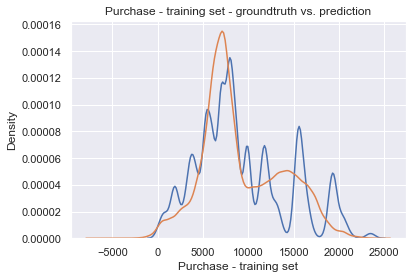

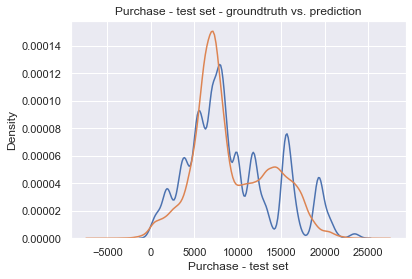

In [2]:
from sklearn.pipeline import Pipeline
from modelling.models import (
    train_eval,
    setup_mlflow
)
from modelling.preprocessing import get_constant_imputed_preprocessor
from data.data import import_data
from xgboost import XGBRegressor


# Set tracking URI and enable autologging 
setup_mlflow()

# Get training data
X, y = import_data("train.csv")

params = {
    'n_estimators': 1000, 'learning_rate': 1, 'max_depth': 5, 'subsample': 1.0, 'gamma': 0,
    'random_state': 0, 'n_jobs': -1
}

xgb_hypertuned_model, xgb_hypertuned_training_perf, xgb_hypertuned_test_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_constant_imputed_preprocessor()),
        ("regressor", XGBRegressor(**params))
    ]),
    model_name="xgb_hypertuned",
    plot_preds=True
)

In [4]:
from modelling.metrics import metrics2df

metrics2df(xgb_hypertuned_training_perf)

,Metric value
RMSE,2202.825665
MAE,1641.133811
MedAE,1256.169922
explained_variance,0.807475
max_error,15825.478516
R2,0.807475
r2,0.807550


In [5]:
metrics2df(xgb_hypertuned_test_perf)

,Metric value
RMSE,2550.470616
MAE,1873.364895
MedAE,1409.109863
explained_variance,0.742827
max_error,16878.315186
R2,0.742827
r2,0.743625


Compared to the baseline showed in [Training experiments](https://github.com/aliz-ai/ml-spec-2022/blob/demo2/Demo%20%232/notebooks/3.%20Training%20experiments.ipynb), we can highlight the following remarks:
- the XGBoost better learns on the training set (XGBoost RMSE = 2203 vs. baseline RMSE = 2952)
- XGBoost performs a better than the baseline on the test set (XGBoost RMSE = __2550__ vs. baseline RMSE = __2956__) - which is due to the more sophisticated nature of the ensemble of decision trees compared to a linear regression
- in terms of plots, the XGBoost has a smoother behavior while the baseline really tries to fit to the groundtruth distribution 
- during hyperparameter optimization, we found a better fit compared to the baseline XGBoost model. However, is was still not enough to beat the linear regression.

At that stage, we can guess that the XGBoost could be better optimised with a longer hypertuning phase.
_Keep in mind that for the sake of a simple demonstration, we set the hypertuning phase to a maximum of 20 trials only, which is quite mean compared to the hyperparameter space to explore._
<br>Another consideration would be to even broaden the hyperparameter space to other hyperparameters like `gamma` or `subsample`.

## Hyperparameter tuning using Optuna

Models with short training times should be optimized locally for hyperparameters. Although the Vertex AI offers a good option, it is especially worth using for high-computational models, as jobs start up in a relatively long time.

Optuna is a hyperparameter optimization framework. It offers a good local alternative to Vertex AI. Other similar frameworks such as Hyperopt can also be used as well.

In [6]:
import optuna
from hyperparameter_optimization.hyperopt_w_optuna import objective


study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=20
)

print(study.best_trial)

[I 2022-06-08 22:59:31,578] A new study created in memory with name: no-name-5bbf2abd-dad4-419c-b36b-00af93149bd5
2022/06/08 22:59:36 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 22:59:36 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 22:59:36 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
   

Training...


2022/06/08 23:01:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\gbenc\AppData\Local\Temp\tmpk3vv967j\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.1.0']. Set logging level to DEBUG to see the full traceback.
2022/06/08 23:01:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 120.03 s


[I 2022-06-08 23:01:48,246] Trial 0 finished with value: 2857.2589264933717 and parameters: {'max_depth': 8, 'learning_rate': 0.02668844021721044, 'n_estimators': 231}. Best is trial 0 with value: 2857.2589264933717.
2022/06/08 23:01:50 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:01:50 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:01:50 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:04:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\gbenc\AppData\Local\Temp\tmp692mzgea\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.1.0']. Set logging level to DEBUG to see the full traceback.
2022/06/08 23:04:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 158.33 s


[I 2022-06-08 23:04:45,978] Trial 1 finished with value: 2843.828190823426 and parameters: {'max_depth': 7, 'learning_rate': 0.028590170041303486, 'n_estimators': 351}. Best is trial 1 with value: 2843.828190823426.
2022/06/08 23:04:48 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:04:48 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:04:49 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:04:49 WARNING mlflow.utils: Truncated the value of the key `preprocessor__cat`. Truncated value: `Pipeline(steps=[('cast',
                 FunctionTransformer(func=<function cast at 0x0000024D728F6EE8>)),
                ('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot', OneHotEn...`
2022/06/08 23:05:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:05:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 60.96 s


[I 2022-06-08 23:05:57,993] Trial 2 finished with value: 3084.8180587450665 and parameters: {'max_depth': 3, 'learning_rate': 0.02829053289643457, 'n_estimators': 236}. Best is trial 1 with value: 2843.828190823426.
2022/06/08 23:06:00 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:06:00 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:06:00 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:11:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:11:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 325.45 s


[I 2022-06-08 23:11:40,569] Trial 3 finished with value: 2669.663633985782 and parameters: {'max_depth': 8, 'learning_rate': 0.07123454714534014, 'n_estimators': 728}. Best is trial 3 with value: 2669.663633985782.
2022/06/08 23:11:42 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:11:42 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:11:42 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/06/08 23:14:31 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:14:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 168.62 s


[I 2022-06-08 23:14:42,028] Trial 4 finished with value: 2865.415170636307 and parameters: {'max_depth': 6, 'learning_rate': 0.018615073827333954, 'n_estimators': 590}. Best is trial 3 with value: 2669.663633985782.
2022/06/08 23:14:44 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:14:44 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:14:44 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:19:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:19:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 285.51 s


[I 2022-06-08 23:19:44,509] Trial 5 finished with value: 2716.834481449046 and parameters: {'max_depth': 7, 'learning_rate': 0.04557560535641512, 'n_estimators': 865}. Best is trial 3 with value: 2669.663633985782.
2022/06/08 23:19:46 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:19:46 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:19:46 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/06/08 23:21:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:21:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 102.01 s


[I 2022-06-08 23:21:37,285] Trial 6 finished with value: 2662.953191905554 and parameters: {'max_depth': 5, 'learning_rate': 0.2652117581581142, 'n_estimators': 370}. Best is trial 6 with value: 2662.953191905554.
2022/06/08 23:21:39 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:21:39 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:21:39 WARNING mlflow.utils: Truncated the value of the key `r

Training...


2022/06/08 23:25:35 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:25:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 236.98 s


[I 2022-06-08 23:25:49,684] Trial 7 finished with value: 2541.7939322866014 and parameters: {'max_depth': 10, 'learning_rate': 0.7039121253118034, 'n_estimators': 458}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:25:52 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:25:52 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:25:52 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:28:50 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:28:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 179.06 s


[I 2022-06-08 23:29:02,023] Trial 8 finished with value: 2544.5722237842256 and parameters: {'max_depth': 4, 'learning_rate': 0.5121712096341543, 'n_estimators': 832}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:29:04 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:29:04 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:29:04 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:31:06 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:31:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 123.45 s


[I 2022-06-08 23:31:17,348] Trial 9 finished with value: 2849.9237715051854 and parameters: {'max_depth': 9, 'learning_rate': 0.01774760338521065, 'n_estimators': 260}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:31:19 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:31:19 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:31:19 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:32:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:32:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 55.09 s


[I 2022-06-08 23:32:20,911] Trial 10 finished with value: 2646.8856041713743 and parameters: {'max_depth': 10, 'learning_rate': 0.9785518940862438, 'n_estimators': 68}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:32:22 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:32:22 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:32:22 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:34:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:34:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 98.42 s


[I 2022-06-08 23:34:09,417] Trial 11 finished with value: 2577.627425469169 and parameters: {'max_depth': 3, 'learning_rate': 0.7225779188268917, 'n_estimators': 550}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:34:11 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:34:11 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:34:11 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:38:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:38:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 274.47 s


[I 2022-06-08 23:39:02,219] Trial 12 finished with value: 2571.5763726966193 and parameters: {'max_depth': 5, 'learning_rate': 0.259588384417776, 'n_estimators': 987}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:39:04 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:39:04 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:39:04 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/06/08 23:41:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:41:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 161.04 s


[I 2022-06-08 23:41:57,140] Trial 13 finished with value: 2591.133777965657 and parameters: {'max_depth': 4, 'learning_rate': 0.36198474605221426, 'n_estimators': 706}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:41:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:41:59 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:41:59 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:48:40 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:48:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 401.45 s


[I 2022-06-08 23:49:01,287] Trial 14 finished with value: 2578.1085319609483 and parameters: {'max_depth': 10, 'learning_rate': 0.14065608616445088, 'n_estimators': 720}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:49:03 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:49:03 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:49:03 WARNING mlflow.utils: Truncated the value of the k

Training...


2022/06/08 23:51:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:51:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 161.64 s


[I 2022-06-08 23:51:55,462] Trial 15 finished with value: 2574.2523129057226 and parameters: {'max_depth': 5, 'learning_rate': 0.5128903404218507, 'n_estimators': 458}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:51:57 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:51:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:51:58 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/08 23:56:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:56:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 279.90 s


[I 2022-06-08 23:56:55,003] Trial 16 finished with value: 2600.0284897477786 and parameters: {'max_depth': 6, 'learning_rate': 0.17779375913617973, 'n_estimators': 867}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:56:58 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:56:58 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:56:58 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/06/08 23:59:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/08 23:59:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 148.28 s


[I 2022-06-08 23:59:38,479] Trial 17 finished with value: 2575.4156455992556 and parameters: {'max_depth': 4, 'learning_rate': 0.5039446802550684, 'n_estimators': 598}. Best is trial 7 with value: 2541.7939322866014.
2022/06/08 23:59:41 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/08 23:59:41 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/08 23:59:41 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/09 00:03:32 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/09 00:03:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 232.43 s


[I 2022-06-09 00:03:49,027] Trial 18 finished with value: 2682.621956656821 and parameters: {'max_depth': 9, 'learning_rate': 0.08125775919085419, 'n_estimators': 452}. Best is trial 7 with value: 2541.7939322866014.
2022/06/09 00:03:51 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/09 00:03:51 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/09 00:03:51 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/06/09 00:07:09 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/09 00:07:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 199.46 s


[I 2022-06-09 00:07:24,528] Trial 19 finished with value: 2532.068671438991 and parameters: {'max_depth': 4, 'learning_rate': 0.9388208801828383, 'n_estimators': 846}. Best is trial 19 with value: 2532.068671438991.


FrozenTrial(number=19, values=[2532.068671438991], datetime_start=datetime.datetime(2022, 6, 9, 0, 3, 49, 28974), datetime_complete=datetime.datetime(2022, 6, 9, 0, 7, 24, 528523), params={'max_depth': 4, 'learning_rate': 0.9388208801828383, 'n_estimators': 846}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'learning_rate': LogUniformDistribution(high=1.0, low=0.01), 'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)


With Optuna we have found the following hyperparameter values as best ones:

- `max_depth` = 4
- `learning_rate` = 0.9388208801828383
- `n_estimators` = 846
- `subsample` = 1
- `gamma` = 0


Let's freeze those hyperparameter values and make some additional experiments to have a more detailed picture.
<br>Plot the distributions of predictions with these hyperparameters.

2022/06/09 00:08:35 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
             ...`
2022/06/09 00:08:35 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000024D728F6E58>)),
                               ...`
2022/06/09 00:08:35 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=0, gpu_id=Non

Training...


2022/06/09 00:12:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}
2022/06/09 00:12:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


   Training time: 250.14 s


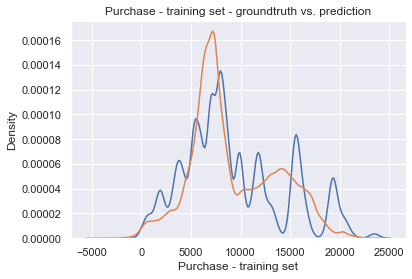

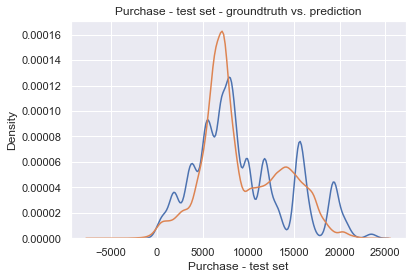

In [7]:
params = {
    'n_estimators': 846, 'learning_rate': 0.9388208801828383, 'max_depth': 4, 'subsample': 1.0, 'gamma': 0,
    'random_state': 0, 'n_jobs': -1
}

xgb_optuna_model, xgb_optuna_training_perf, xgb_optuna_test_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_constant_imputed_preprocessor()),
        ("regressor", XGBRegressor(**params))
    ]),
    model_name="xgb_optuna",
    plot_preds=True
)

In [8]:
metrics2df(xgb_optuna_training_perf)

,Metric value
RMSE,2337.957728
MAE,1743.181527
MedAE,1339.525879
explained_variance,0.783130
max_error,15955.931641
R2,0.783130
r2,0.783259


In [9]:
metrics2df(xgb_optuna_test_perf)

,Metric value
RMSE,2532.068671
MAE,1870.027059
MedAE,1420.346191
explained_variance,0.746525
max_error,17216.328125
R2,0.746525
r2,0.746615



XGBoost with hypermaraters found by Optuna generalizes better as it achieves a better test (Optuna RMSE = __2532__ vs. Vertex AI Hyperopt RMSE = __2550__ vs. baseline XGBoost RMSE = __2956__) and a worse training (Optuna RMSE = 2337 vs. Vertex AI Hyperopt RMSE = 2203 vs. baseline XGBoost RMSE = 2952) RMSE.

We would not conclude from this that one is better than the other. Optuna just found one of the better combinations by chance. Over a longer run, the results would converge.

However, it is worth noting that there is a case where local hyperparameter optimization may be more advantageous then Vertex AI's which also has its benefits.